## Part 3
Now go to the set of 29 images and repeat everything you did in Part 2 above for this larger dataset. 

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math
import glob
import os
import itertools

In [2]:
# Part 1 Functions
def normalize_images(imgs):
    imgs_norm = []
    for img in imgs:
        img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        imgs_norm.append(img_norm)
    return imgs_norm

def grayscale_images(imgs):
    imgs_gray = []
    for img in imgs:
        gr = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Apply CLAHE to grayscale images
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        imgs_gray.append(clahe.apply(gr))
    return imgs_gray

def find_features(sift_object, imgs_gray):
    kp = []
    des = []
    imgs_sift = []
    for img in imgs_gray:
        k, d = sift_object.detectAndCompute(img,None)
        img_sift = cv2.drawKeypoints(img, k, img, color=[255,255,0], flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        imgs_sift.append(img_sift)
        kp.append(np.array(k))
        des.append(np.array(d))
    return kp, des, imgs_sift

def get_matches(kp1, des1, kp2, des2):
    # FLANN parameters https://docs.opencv.org/4.x/d1/de0/tutorial_py_feature_homography.html 
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50) # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    flann_match = flann.knnMatch(des1,des2,k=2)
    # Need to draw only good matches, so create a mask
    good = []

    # ratio test as per Lowe's paper
    for m,n in flann_match:
        if m.distance < 0.7*n.distance:
            good.append(m)

    src_pts = np.array([kp1[m.queryIdx].pt for m in good])
    dst_pts = np.array([kp2[m.trainIdx].pt for m in good])

    return (src_pts, dst_pts)

def get_all_matches(kp, des):
    matches = []
    if len(kp) == 6:
        last_img_match = 0
    elif len(kp) == 28:
        last_img_match = 13
    else:
        print("Length of keypoints not expected")
        
    for i in range(len(kp)):
        ii = i+1 if i < len(kp)-1 else last_img_match
        matches.append(get_matches(kp[i], des[i], kp[ii], des[ii]))
        print("Image: ", i, ", ", ii, " Matches: ", len(matches[i][0]))

    return matches


def get_homography(kp_match_inliers):
    h = []
    pts_left_src = []
    pts_right_dst = []
    mask = []

    # if inliers were not already given to the homography function, get points and do RANSAC
    for kp_match in kp_match_inliers:
        pts_left_src.append(np.float32([kp_match[0][i] for i in range(len(kp_match[0]))]))
        pts_right_dst.append(np.float32([kp_match[1][i] for i in range(len(kp_match[1]))]))

    # this is only for the last run
    for i in range(len(pts_left_src)):
        h_img, mask_img = cv2.findHomography(pts_right_dst[i],pts_left_src[i],cv2.RANSAC,3.0)
        h.append(h_img)
        mask.append(mask_img)
    return h, mask, (pts_left_src, pts_right_dst)

def adjust_image_frame(H, src_shape, dst_shape):
    # Get corners of the source image
    (h, w) = src_shape
    img_corners = np.float32([[0, 0],
                            [w - 1, 0],
                            [w - 1, h - 1],
                            [0, h - 1]])
    
    # Convert to Array in Homogeneous Coordinates
    corners_base = np.array([img_corners[:, 0],
                            img_corners[:,1],
                            np.ones(4)])

    # Calculate distorted corner pixel coordinates by multiplying by Homography matrix
    corners_distorted = np.dot(H, corners_base)
    [x, y, c] = corners_distorted
    x = np.divide(x, c)
    y = np.divide(y, c)

    # Finding the dimentions of the distorted image frame
    min_x, max_x = int(round(min(x))), int(round(max(x)))
    min_y, max_y = int(round(min(y))), int(round(max(y)))

    # Fit Right Side of Image
    w_stitched = max(max_x, dst_shape[1])
    h_stitched = max(max_y, dst_shape[0])

    # Add offset if distorted stitching goes out of current image frame
    offset = [0, 0]
    if min_x < 0:
        offset[0] = abs(min_x)
        w_stitched += offset[0]
    if min_y < 0:
        offset[1] = abs(min_y)
        h_stitched += offset[1]

    # Add offset to stitched corner coordinates
    corners_stitched = np.float32(np.array([x + offset[0], y + offset[1]]).transpose())

    # Recompute homography s.t. the source image is in frame
    H = cv2.getPerspectiveTransform(img_corners, corners_stitched)
    
    return [h_stitched, w_stitched], offset, H


def alpha_blending(img1, img2):
    # Blend images together
    black = np.zeros(img1.shape, dtype=np.uint8)
    mask_dst = cv2.inRange(img1, np.array([0,0,0]), np.array([0,0,0]))
    mask_src = cv2.inRange(img2, np.array([0,0,0]), np.array([0,0,0]))

    # Get the non-overlapping components of both images
    dst_fringe = cv2.bitwise_or(img1, img2, mask=mask_dst)
    src_fringe = cv2.bitwise_or(img1, img2, mask=mask_src)

    # Get the overlapping region and set it to white to use as a mask
    overlap_region = cv2.bitwise_and(
        cv2.bitwise_or(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), mask=cv2.bitwise_not(mask_dst)),
        cv2.bitwise_or(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), mask=cv2.bitwise_not(mask_src)))
    overlap_region[overlap_region>0.0] = 255

    # Blend only the overlapping regions of the image
    img_overlap_blend = cv2.addWeighted(
        cv2.bitwise_or(img2, black, mask=overlap_region), 0.5,
        cv2.bitwise_or(img1, black, mask=overlap_region), 0.5, 0.0)

    return dst_fringe + src_fringe + img_overlap_blend


def stitch_images(img_dst, img_src, H):
    # Finding size of new frame of stitched images and updating the homography matrix 
    stitched_dims, offset, H = adjust_image_frame(H, img_src.shape[:2], img_dst.shape[:2])
    print(stitched_dims)
    # Finally placing the images upon one another.
    src_warped = cv2.warpPerspective(img_src, H, (stitched_dims[1], stitched_dims[0]))

    # Expand destimation image frame to fit source image
    dst_transformed = np.zeros((stitched_dims[0], stitched_dims[1], 3), dtype=np.uint8)
    dst_transformed[offset[1]:offset[1]+img_dst.shape[0], offset[0]:offset[0]+img_dst.shape[1]] = img_dst

    img_stitched = alpha_blending(dst_transformed, src_warped)

    return img_stitched, offset

In [3]:
imgs = []
dir_name = '29images/'
list_of_files = sorted( filter( os.path.isfile,
                        glob.glob(dir_name + '*') ) )
# Iterate over sorted list of files and print the file paths 
# one by one.
for file_path in list_of_files:
    imgs.append(cv2.imread(file_path))

In [4]:
imgs_norm = normalize_images(imgs)
imgs_gray = grayscale_images(imgs_norm)
img_h, img_w = imgs_gray[0].shape

# Create SIFT Object and save keypoints, descriptors, and sift-labeled images
sift = cv2.SIFT_create(nfeatures=5000, nOctaveLayers=16, contrastThreshold=0.025, edgeThreshold=10, sigma=1.4)
kp, des, imgs_sift = find_features(sift, imgs_gray)

matches = get_all_matches(kp, des)

Image:  0 ,  1  Matches:  410
Image:  1 ,  2  Matches:  247
Image:  2 ,  3  Matches:  215
Image:  3 ,  4  Matches:  305
Image:  4 ,  5  Matches:  102
Image:  5 ,  6  Matches:  192
Image:  6 ,  7  Matches:  56
Image:  7 ,  8  Matches:  512
Image:  8 ,  9  Matches:  585
Image:  9 ,  10  Matches:  591
Image:  10 ,  11  Matches:  571
Image:  11 ,  12  Matches:  393
Image:  12 ,  13  Matches:  51
Image:  13 ,  14  Matches:  558
Image:  14 ,  15  Matches:  481
Image:  15 ,  16  Matches:  763
Image:  16 ,  17  Matches:  575
Image:  17 ,  18  Matches:  746
Image:  18 ,  19  Matches:  825
Image:  19 ,  20  Matches:  263
Image:  20 ,  21  Matches:  532
Image:  21 ,  22  Matches:  711
Image:  22 ,  23  Matches:  381
Image:  23 ,  24  Matches:  577
Image:  24 ,  25  Matches:  569
Image:  25 ,  26  Matches:  463
Image:  26 ,  27  Matches:  375
Image:  27 ,  13  Matches:  198


(-0.5, 1362.5, 1296.5, -0.5)

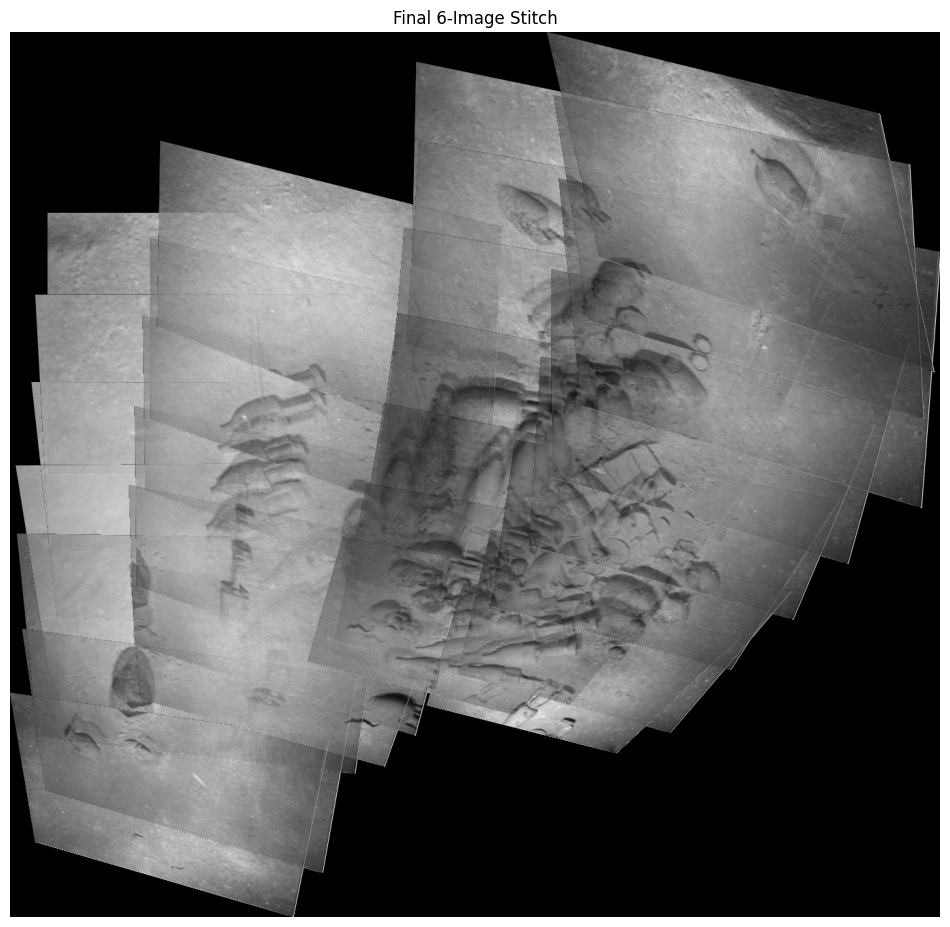

In [5]:
h, mask, pts_corr = get_homography(matches)

t = [0,0]
#mosaicImgs = []
for i in range(len(h)-1):
    #print(h[i])
    h[i][0][2] += t[0]
    h[i][1][2] += t[1]
    if i != 0:
        h[i] = np.dot(h[i],h[i-1])
    if i == 0:
        mosaicImg, t = stitch_images(imgs_norm[i],imgs_norm[i+1],h[i])
        

    elif i > 0 and i < len(h):
        mosaicImg, t = stitch_images(mosaicImg,imgs_norm[i+1],h[i])
        
    else:
        mosaicImg, t = stitch_images(mosaicImg,imgs_norm[0],h[i])
    
    #mosaicImgPrev = mosaicImg
    #t = tNew
plt.figure(figsize = (12,12))
plt.imshow(mosaicImg)
plt.title("Final 6-Image Stitch")
plt.axis('off')

In [6]:
#import g2o
import gtsam
import gtsam.utils.plot

In [7]:
def getOdometryNoise(mask):
    numMatches = np.count_nonzero(mask)
    # define error lists in the form of [xerr,yerr,theta_err]
    minError = [0.2, 0.2, 0.1]
    smallError = [0.5, 0.5, 0.25]
    largeError = [0.8, 0.8, 0.4]
    maxError = [1.0, 1.0, 0.5]
    
    if numMatches > 100:
        err = minError
    elif numMatches > 50 and numMatches <= 100:
        err = smallError
    elif numMatches > 20 and numMatches <= 50:
        err = largeError
    else:
        # less than 20 inlier matches
        err = maxError
    
    return gtsam.noiseModel.Diagonal.Sigmas(gtsam.Point3(err[0], err[1], err[2]))

In [8]:
PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(gtsam.Point3(0.3, 0.3, 0.1))
graph = gtsam.NonlinearFactorGraph()

# add a prior on the first pose at origin (image 0 center)
graph.add(gtsam.PriorFactorPose2(0, gtsam.Pose2(img_w/2, img_h/2, 0), PRIOR_NOISE))

In [9]:
ransac_mask = []
def getFactorPose(index, pts_src = pts_corr[0], pts_dst = pts_corr[1]):
    global ransac_mask

    similarity_mat, ransac_mask = cv2.estimateAffinePartial2D(pts_dst[index],pts_src[index])
    scale = np.sqrt(similarity_mat[0, 0]**2+similarity_mat[1, 0]**2)
    similarity_mat[:2, :2] /= scale
    affine_matrix = np.vstack((similarity_mat, [0, 0, 1]))

    return gtsam.Pose2(affine_matrix[0, -1], affine_matrix[1, -1],
                np.arctan2(affine_matrix[1, 0], affine_matrix[0, 0]))
        
getFactorPose(0)

(-14.9155, 123.128, -0.00625477)

In [10]:
def extractHomographyPose(h):
   affineEst = h
   affineEst[2][0] = 0
   affineEst[2][1] = 0
   #print(affineEst)
   scale = np.sqrt(affineEst[0,0]**2+affineEst[1,0]**2) # adapted from ZZ
   affineEst[:2, :2] /= scale
   rot = affineEst[:2, :2]
   total_affine_matrix = np.eye(3)

   affineEst_inv = np.linalg.inv(affineEst)
   affineEst = affineEst_inv.dot(total_affine_matrix)
   return gtsam.Pose2(affineEst[0, -1], affineEst[1, -1],
                  np.arctan2(affineEst[1, 0], affineEst[0, 0]))

In [11]:
def initialEstimates(h):
    initial_estimate = gtsam.Values()
    initial_estimate.insert(0, gtsam.Pose2())
    
    for i in range(len(h)-1):
        initial_estimate.insert(i+1, extractHomographyPose(h[i]))
        
    return initial_estimate

initial = initialEstimates(h)

In [12]:
def plot_graph(values, graph, marginals):

    for vertex_index in range(values.size()):
        gtsam.utils.plot.plot_pose2(0, values.atPose2(
            vertex_index), 0.5, marginals.marginalCovariance(vertex_index))

    for edge_index in range(graph.size())[1:]:
        key1, key2 = graph.at(edge_index).keys()

        start_pose = values.atPose2(key1)
        end_pose = values.atPose2(key2)
        plt.plot([start_pose.x(), end_pose.x()],
                 [start_pose.y(), end_pose.y()],
                 color='blue')

    plt.show()

In [13]:
# nonlinear graph initialization done earlier
for src_index, dst_index in itertools.combinations(range(len(imgs_norm)), 2):
    #print(dst_index)
    #print(check_overlap(initial.atPose2(src_index), initial.atPose2(dst_index)))

    if src_index + 1 == dst_index:
        graph.add(gtsam.BetweenFactorPose2(src_index, dst_index,
                                               getFactorPose(src_index), getOdometryNoise(mask[src_index])))
            
    else: 
    # 
    #elif src_index + 2 == dst_index or src_index - 2 == dst_index or src_index - 1 == dst_index:
    #elif src_index + 2 == dst_index or src_index - 2 == dst_index or src_index - 1 == dst_index or dst_index % 7 < 3:
    #elif check_overlap(initial.atPose2(src_index), initial.atPose2(dst_index)):
        # NOTE: Need to change this to check only images immediately next to it
        #homog, maskIm = registerTwoImages(normImgs,src_index,dst_index,kp,des)


        kp_match_overlap = [get_matches(kp[src_index], des[src_index], kp[dst_index], des[dst_index])]
        
        print(len(kp_match_overlap[0][0]))
        if len(kp_match_overlap[0][0]) < 20: continue
        homog, maskIm, _ = get_homography(kp_match_overlap)

        pts_left_overlap = []
        pts_right_overlap = []
        for kp_matches in kp_match_overlap:
            pts_left_overlap.append(np.float32([kp_matches[0][i] for i in range(len(kp_matches[0]))]))
            #print(pts_left_src)
            pts_right_overlap.append(np.float32([kp_matches[1][i] for i in range(len(kp_matches[1]))]))

        #print(len(pts_left_overlap[0]))
        factor_pose = getFactorPose(0, pts_left_overlap, pts_right_overlap)
        #print(factor_pose)
        if factor_pose is not None:
            graph.add(gtsam.BetweenFactorPose2(src_index, dst_index,
                                factor_pose, getOdometryNoise(ransac_mask)))


83
2
4
3
2
6
2
2
2
21
84
1
1
7
2
4
2
2
0
1
6
3
4
2
4
1
21
6
3
4
9
5
3
12
73
128
7
5
7
4
3
6
8
3
6
6
9
4
3
5
8
64
10
3
18
8
56
96
168
73
6
4
8
13
3
10
6
4
3
8
6
6
2
10
12
11
5
19
29
131
147
101
9
5
8
8
6
7
13
8
4
5
10
12
7
4
9
7
10
44
90
192
126
60
7
4
2
5
2
5
6
6
2
5
8
7
8
6
4
3
127
92
22
5
9
11
5
8
6
13
5
7
3
5
3
6
6
4
4
6
10
17
1
2
1
7
7
2
8
4
1
4
4
3
2
9
4
2
4
2
4
103
11
4
3
3
2
9
1
8
19
32
4
6
8
5
5
4
3
1
136
8
6
4
4
6
9
26
26
21
6
3
2
4
3
4
5
3
154
7
10
12
17
40
34
14
11
12
5
5
7
8
7
4
8
111
3
14
52
43
24
6
3
4
2
6
4
6
6
7
5
8
35
26
26
7
4
9
4
7
4
4
2
2
1
10
62
14
4
6
4
4
2
4
4
5
2
5
4
3
94
4
1
1
2
1
2
1
4
3
50
158
203
151
3
6
3
3
1
5
19
113
250
232
69
134
7
4
6
5
15
148
391
283
95
6
43
2
7
4
52
330
441
162
11
10
187
20
140
269
301
155
26
18
4
137
359
372
73
20
7
13
9
376
192
19
11
10
7
6
103
7
7
4
4
4
64
6
5
9
9
56
10
8
8
133
2
7
94
2
54


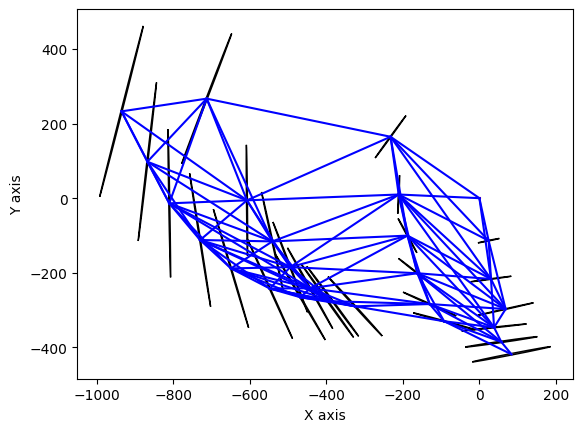

In [14]:
marginals = gtsam.Marginals(graph, initial)
plot_graph(initial, graph, marginals)

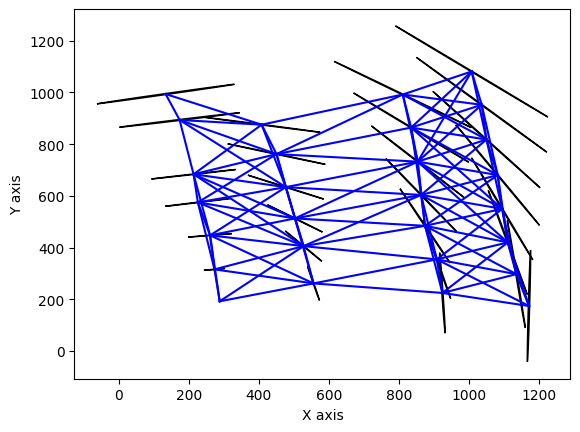

In [15]:
params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)


#params = gtsam.GaussNewtonParams()
# Stop iterating once the change in error between steps is less than this value
#params.setRelativeErrorTol(1e-5)
# Do not perform more than N iteration steps
#params.setMaxIterations(100)
#optimizer = gtsam.GaussNewtonOptimizer(graph, initial, params)
initial = optimizer.optimize()
marginals = gtsam.Marginals(graph, initial)
plot_graph(initial, graph, marginals)

In [16]:
def extractAffineMatrixList(initial, image_list):
    poses = gtsam.utilities.allPose2s(initial)
    affine_matrix_list = []

    for index in range(len(image_list)):

        pose = poses.atPose2(index)
        #print(pose)
        #pose = [x * -1 for x in pose]
        affine_matrix = pose.matrix()
        #affine_matrix = np.linalg.inv(affine_matrix)
        translation_matrix = np.eye(3)

        translation_matrix[:2, 2] -= np.array([img_w/2, img_h/2]).T
        #print(affine_matrix.dot(translation_matrix))
        #affine_matrix_list.append(affine_matrix)
        affine_matrix_list.append(affine_matrix.dot(translation_matrix))
    
    #print(affine_matrix_list[0])
    affine_matrix_list.reverse()
    return affine_matrix_list

In [17]:
affine_matrix_list = extractAffineMatrixList(initial, imgs_norm)

In [18]:
def get_warp_point(homography_matrix, point):
    warp_point = homography_matrix.dot(np.append(point, [1]).T)
    return (warp_point / warp_point[-1])[:2]

In [19]:
def get_stitch_image_size_offset_affine_matrix(homography_matrix_list):
    corner_point_list = []

    for homography_matrix in homography_matrix_list:

        corner_point_list.append(get_warp_point(
            homography_matrix, [0, 0]))
        corner_point_list.append(get_warp_point(
            homography_matrix, [img_w - 1, 0]))
        corner_point_list.append(get_warp_point(
            homography_matrix, [img_w - 1, img_h - 1]))
        corner_point_list.append(get_warp_point(
            homography_matrix, [0, img_h - 1]))

    min_point = (np.floor(np.amin(corner_point_list, axis=0))).astype(np.int32)
    max_point = (np.ceil(np.amax(corner_point_list, axis=0))).astype(np.int32)

    stitch_image_size = tuple(max_point - min_point + 1)

    offset_affine_matrix = np.eye(3, dtype=np.float64)
    if min_point[0] < 0:
        offset_affine_matrix[0, -1] -= min_point[0]
    if min_point[1] < 0:
        offset_affine_matrix[1, -1] -= min_point[1]
    return stitch_image_size, offset_affine_matrix

In [21]:
def get_stitch_image(homography_matrix_list, image_list, stitch_image_size, offset_affine_matrix):

    stitch_image = np.zeros(
        (stitch_image_size[1], stitch_image_size[0], 3), np.uint8)
    print(stitch_image.shape)
    image_list.reverse()
    for homography_matrix, image in zip(homography_matrix_list, image_list):
        
        warp_image = cv2.warpPerspective(
            image, offset_affine_matrix.dot(homography_matrix), stitch_image_size)
        #plt.imshow(warp_image)
        #break
        warp_image_mask = (warp_image != 0)
        stitch_image[warp_image_mask] = warp_image[warp_image_mask]
        
        
        output = alpha_blending(stitch_image,warp_image)
    

    return output

(1371, 1664, 3)


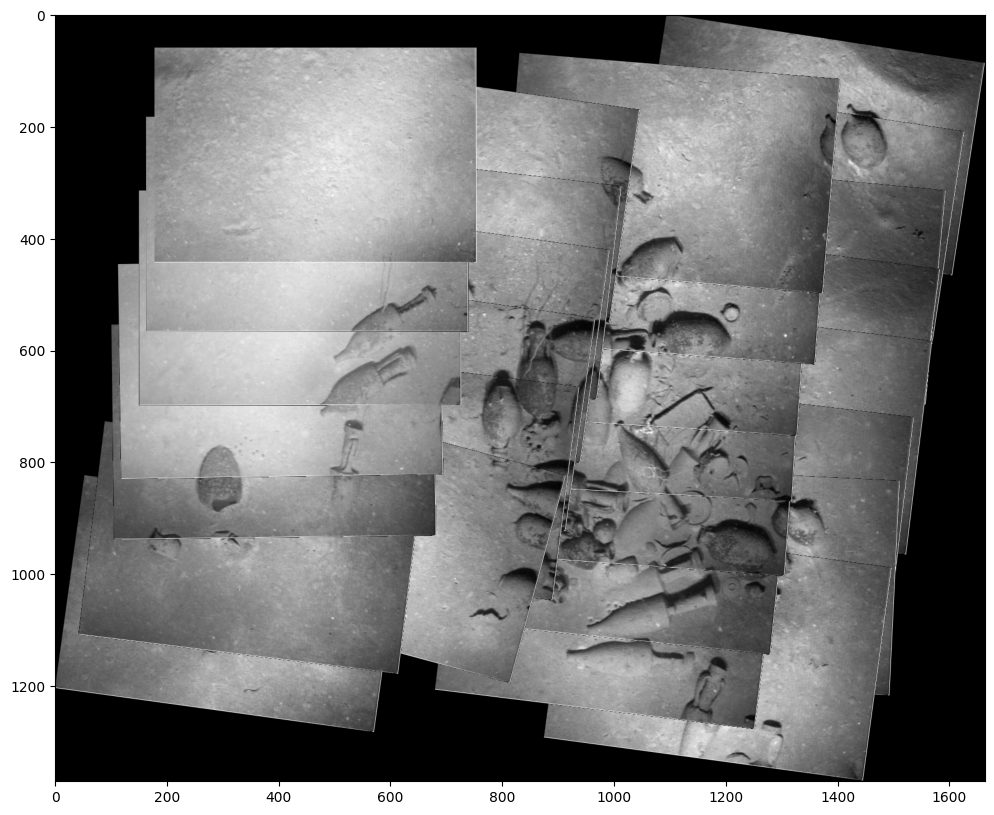

In [22]:
stitch_image_size, offset_affine_matrix = get_stitch_image_size_offset_affine_matrix(
    affine_matrix_list)

stitch_image = get_stitch_image(
    affine_matrix_list, imgs_norm, stitch_image_size, offset_affine_matrix)

plt.figure(figsize = (12,12))
plt.imshow(stitch_image)
plt.show()